In [16]:
!pip install xgboost


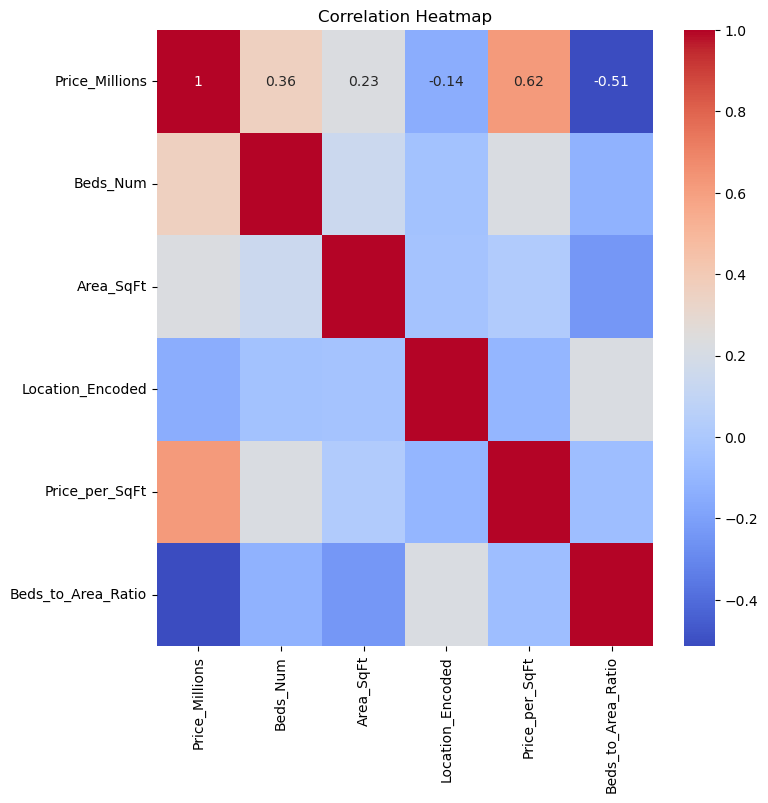

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the cleaned data
df = pd.read_csv('clean_islamabad_properties.csv')

# Feature Engineering
df['Price_per_SqFt'] = df['Price_Millions'] * 1000000 / df['Area_SqFt']
df['Beds_to_Area_Ratio'] = df['Beds_Num'] / df['Area_SqFt']

# Exploratory Data Analysis
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [44]:

print("Location Encoding:")
for location, code in location_mapping.items():
    print(f"{location}: {code}")

Location Encoding:
AGHOSH Phase 1, AGHOSH: 0
AGHOSH, Islamabad: 1
AWT - Block B, AWT: 2
AWT - Block D, AWT: 3
AWT, D-18: 4
Airline Avenue, Islamabad: 5
Airport Avenue Housing Society, Islamabad: 6
Airport Enclave A, Airport Enclave: 7
Airport Enclave, Islamabad: 8
Airport Green Garden - Block B, Airport Green Garden: 9
Ali Pur, Islamabad: 10
Aryan Enclave, Bani Gala: 11
Athal, Islamabad: 12
B-17, Islamabad: 13
Bahria Enclave - Sector A, Bahria Enclave: 14
Bahria Enclave - Sector B1, Bahria Enclave: 15
Bahria Enclave - Sector B2, Bahria Enclave: 16
Bahria Enclave - Sector C, Bahria Enclave: 17
Bahria Enclave - Sector C1, Bahria Enclave: 18
Bahria Enclave - Sector C2, Bahria Enclave: 19
Bahria Enclave - Sector C3, Bahria Enclave: 20
Bahria Enclave - Sector F1, Bahria Enclave: 21
Bahria Enclave - Sector G, Bahria Enclave: 22
Bahria Enclave - Sector H, Bahria Enclave: 23
Bahria Enclave - Sector I, Bahria Enclave: 24
Bahria Enclave - Sector J, Bahria Enclave: 25
Bahria Enclave - Sector M, B

In [50]:
import json
import numpy as np

# Example location mapping with NumPy types
location_mapping = {
    "New York": np.int32(1),
    "Los Angeles": np.int32(2),
    "Chicago": np.int32(3)
}

# Convert all values in the dictionary to standard Python int
location_mapping = {k: int(v) for k, v in location_mapping.items()}

# Save the mapping to a JSON file
with open('location_encoding.json', 'w') as f:
    json.dump(location_mapping, f, indent=4)

print("Location encoding saved to 'location_encoding.json'")

Location encoding saved to 'location_encoding.json'


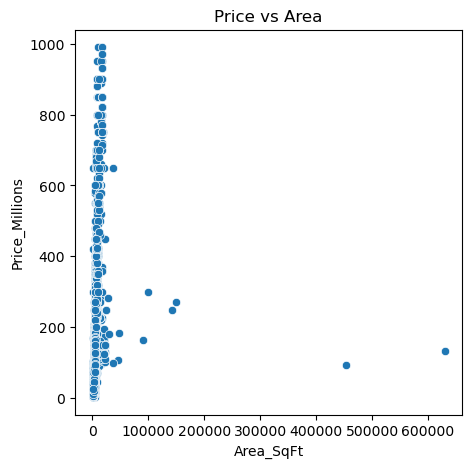

In [56]:

plt.figure(figsize=(5, 5))
sns.scatterplot(x='Area_SqFt', y='Price_Millions', data=df)
plt.title('Price vs Area')
plt.show()


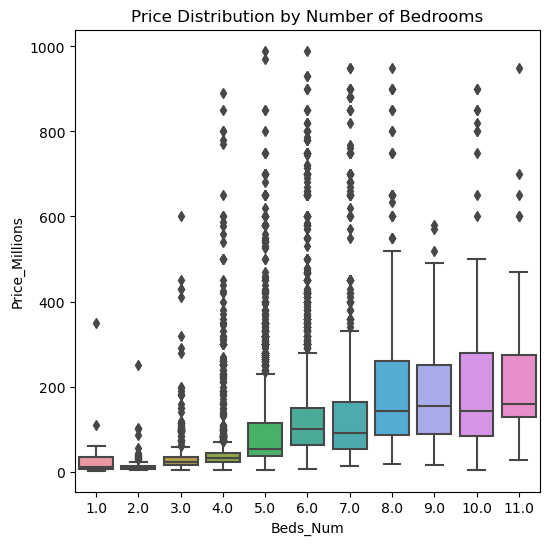

In [34]:

plt.figure(figsize=(6, 6))
sns.boxplot(x='Beds_Num', y='Price_Millions', data=df)
plt.title('Price Distribution by Number of Bedrooms')
plt.show()


In [36]:
# Prepare data for modeling
X = df[['Beds_Num', 'Area_SqFt', 'Location_Encoded', 'Price_per_SqFt', 'Beds_to_Area_Ratio']]
y = df['Price_Millions']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Linear Regression:
MAE: 46.4903
RMSE: 88.0471
R2: 0.6123
CV RMSE: 97.3179

Random Forest:
MAE: 1.5183
RMSE: 11.6473
R2: 0.9932
CV RMSE: 9.8454

XGBoost:
MAE: 2.1655
RMSE: 11.7558
R2: 0.9931
CV RMSE: 10.2981


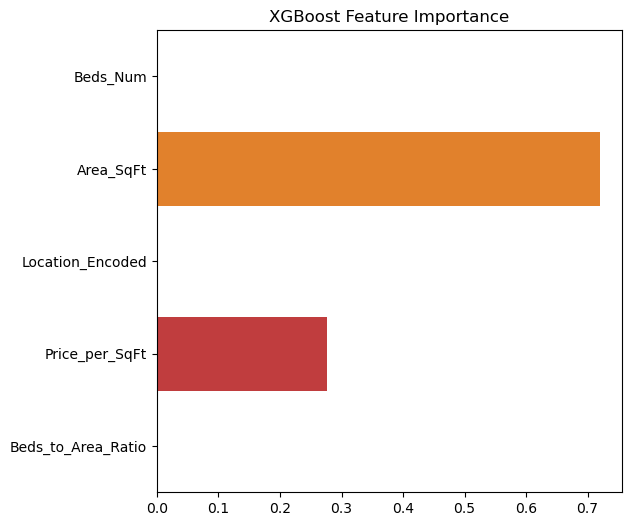

Predicted Price: 5.34 million


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [54]:


# Model Selection and Training
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'CV RMSE': cv_rmse}

# Print results
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Feature Importance (for XGBoost)
xgb_model = models['XGBoost']
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('XGBoost Feature Importance')
plt.show()

# Deployment and Prediction (example)
def predict_price(beds, area, location, model=xgb_model, scaler=scaler):
    # Assuming 'location' is the encoded value
    price_per_sqft = 0  # We'll update this after the first prediction
    beds_to_area_ratio = beds / area
    features = np.array([[beds, area, location, price_per_sqft, beds_to_area_ratio]])
    scaled_features = scaler.transform(features)
    predicted_price = model.predict(scaled_features)[0]
    
    # Update price_per_sqft and predict again
    price_per_sqft = predicted_price * 1000000 / area
    features = np.array([[beds, area, location, price_per_sqft, beds_to_area_ratio]])
    scaled_features = scaler.transform(features)
    final_predicted_price = model.predict(scaled_features)[0]
    
    return final_predicted_price

# Example usage
predicted_price = predict_price(beds=3, area=2000, location=5)  # Assuming '5' is the encoded value for a certain location
print(f"Predicted Price: {predicted_price:.2f} million")


In [52]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Load your trained model and scaler
# Assuming you've saved these using pickle after training
with open('xgb_model.pkl', 'rb') as file:
    model = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Load location encoding
location_mapping = pd.read_json('location_encoding.json', typ='series').to_dict()
reverse_location_mapping = {v: k for k, v in location_mapping.items()}

def predict_price(beds, area, location):
    price_per_sqft = 0  # We'll update this after the first prediction
    beds_to_area_ratio = beds / area
    features = np.array([[beds, area, location, price_per_sqft, beds_to_area_ratio]])
    scaled_features = scaler.transform(features)
    predicted_price = model.predict(scaled_features)[0]
    
    # Update price_per_sqft and predict again
    price_per_sqft = predicted_price * 1000000 / area
    features = np.array([[beds, area, location, price_per_sqft, beds_to_area_ratio]])
    scaled_features = scaler.transform(features)
    final_predicted_price = model.predict(scaled_features)[0]
    
    return final_predicted_price

# Streamlit app
st.title('Islamabad Property Price Predictor')

# User inputs
area = st.number_input('Area (in square feet)', min_value=100, max_value=10000, value=1000)
beds = st.number_input('Number of Bedrooms', min_value=1, max_value=10, value=3)
location = st.selectbox('Location', list(location_mapping.keys()))

if st.button('Predict Price'):
    location_encoded = location_mapping[location]
    price = predict_price(beds, area, location_encoded)
    st.success(f'The predicted price is {price:.2f} million PKR')

# Optional: Add some information about the app
st.info('This app predicts property prices in Islamabad based on area, number of bedrooms, and location.')

FileNotFoundError: [Errno 2] No such file or directory: 'xgb_model.pkl'